# Assignment 3: Extensions to Balanced Colorings and Neutral Landscapes

### Assignment description:

In this assignment you will be asked to extend your last assignment in graph coloring to include finding balanced colorings and exploration of neutral coloring landscapes. Again, we will use the DEAP package in python to handle the genetic algorithm (GA). 

### Assignment goals:

1. Use a genetic algorithm to find balanced colorings for a graph
2. Explore the neutrality of graph colorings

### Assignment question overview:

1. Write a fitness fucntion for the balanced coloring problem. [Question 1 here.](#question1)
2. Paste your fitness function from assignment 2. (not graded) [Question 2 here.](#question2)
3. Write a function to calculate the 1-step neutrality a graph. [Question 3 here.](#question3)


## Balanced Coloring Problem

In the previous assignment our goal was to find any graph coloring such that no two adjacent vertices have the same color. In the balanced coloring problem, we will keep this definition but add a second constraint. That is a coloring in which no particular color is used more than the rest. To implement this problem we will assume that the inputs and graph representation will be the same as the previous assignment. In the balanced graph coloring problem the only thing that will change is the fitness function. 

To start, we will reuse the same set up from the previous assignment. This time the ``init_graph()`` function will be supplied for you. 

In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import math

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

class AdjNode:
    def __init__(self, value):
        self.vertex = value
        self.next = None


class Graph:
    def __init__(self, num, colors):
        self.n = num
        self.k = colors
        self.graph = [None] * self.n
        self.color_assignment = [None] * self.n
        
    def get_node(self, s):
        return self.graph[s]
        
    # Add edges
    def add_edge(self, s, d):
        node = AdjNode(d)  # creates a new node for the destination half of the edge
        node.next = self.graph[s]  # connects the newly-created node to the existing linked list (at the front)
        self.graph[s] = node  # updates the graph list to include the new node (which points to the rest of the list)

        node = AdjNode(s)
        node.next = self.graph[d]
        self.graph[d] = node
        
def init_graph(file):  
    ##open file to read from
    f = open(file, "r")
    ##store n
    n = int(f.readline())
    ##store k
    k = int(f.readline())
    ##instantiate graph obj
    graph = Graph(n,k)
    
    ##get the rest of the lines
    while True:
        str = f.readline()
        ##break if line is empty
        if not str:
            break
        ##add edge to graph
        pair = str.split()
        graph.add_edge(int(pair[0]), int(pair[1]))
            
    f.close()
    return graph


def register_ind(graph):
    ##get value for n and k from graph
    n = graph.n
    k = graph.k
    
    ##calculate the size of each individual
    ind_size = math.ceil(math.log2(k))*n
    
    ##register individual and population with toolbox
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=ind_size)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Fitness Function

Recall that a balanced coloring is a coloring where no two adjacent nodes share the same color **and** no color is used more than others. To find such colorings, we will need to adjust the fitness function accordingly. To do so, we will add an extra penalty term to the original fitness function that will reduce the fitness of unbalanced colorings. Let $G=(V,E)$ be a graph with $n$ nodes and $m$ edges. If $c(i)$ is the assigned color of node $i$, then a coloring of a graph is $C(G)=\{c(0), c(1),...,c(n)\}$. For a given edge, $i,j\in E$, let the function $\delta(i,j)=1$ if $c(i)\not = c(j)$, and $\delta(i,j)=0$ if $c(i)=c(j)$. A fitness function for the balanced coloring problem then is:

$$F(C(G)) = \frac{\sum_{i,j\in E}\delta(i,j)}{m}\prod_{j=1}^{k}\frac{|V_j|}{n}$$

where $|V_j|$ is the size of the set of all nodes of color j.
<a id='question1'></a>
## Question 1: 

Write a fitness function ``eval_balance(graph, indiviudal)`` that computes the fitness of an individual given a graph and an indiviudal. The input will be a graph object and a individual object. The output will be the total fitness of an individual. Use the same indiviudal encoding scheme as in assignment 2. **Remember that if $\lceil log_2(k) \rceil \not= log_2(k)$ then some color encodings will be invalid**. 

In [2]:
def eval_balance(graph, individual):
    edges = []
    section_size = math.ceil(math.log2(graph.k))
    index = 0
    for i in range(0, len(individual), section_size):
        bits = individual[i:i+section_size]
        number = int(''.join(map(str, bits)), 2) 
        graph.color_assignment[index] = number
        index += 1
        
    for i in range (len(graph.graph)):
        edges.append([i,graph.graph[i].vertex])
        temp = graph.graph[i].next
        while temp != None:
            edges.append([i, temp.vertex])
            temp = temp.next
            
    invalids_possible = False
    if math.ceil(math.log2(graph.k)) != math.log2(graph.k):
        invalids_possible = True
    
    color_dict = {i:0 for i in range(2**section_size)}

    for i in range(graph.n):
        color_dict[graph.color_assignment[i]] += 1
    if invalids_possible == True:
        del color_dict[2**section_size - 1]
    bi_color_endpoints = 0
    for i in edges:
        if invalids_possible == True:
            invalid = 2**section_size - 1
            if graph.color_assignment[i[0]] == invalid or graph.color_assignment[i[1]] == invalid:
                return(0,)
        if graph.color_assignment[i[0]] != graph.color_assignment[i[1]]:   
            bi_color_endpoints += 1
    
    penalty_coeff = 1
    for value in color_dict.values():
        penalty_coeff *= value/graph.n
            
    fitness = (bi_color_endpoints/len(edges))*penalty_coeff
    return(fitness,)


Your code should return (0.03125,) for input [0, 1, 0, 0, 1, 0, 0, 1]

In [3]:
graph = init_graph("graphs/graph_1.txt")
register_ind(graph)

ind = creator.Individual([0, 1, 0, 0, 1, 0, 0, 1])

eval_balance(graph, ind)

(0.03125,)

In [4]:
'''
This cell contains hidden tests, which are run on submission.
Test cases 1-10 correspond to graphs/graph_1.txt, test cases 11-20 correspond to graphs/graph_2.txt.
'''
 


'\nThis cell contains hidden tests, which are run on submission.\nTest cases 1-10 correspond to graphs/graph_1.txt, test cases 11-20 correspond to graphs/graph_2.txt.\n'

### Evolving the population

Now that we have all of the necessary functions to create a graph and calculate the fitness of an indiviudal, we can create our population and allow it to evolve. Similar to assignment 2, there are 4 graphs provided. We will need to write a main function that takes a path to the graph file and finds the coloring with the highest fitness. 

In [5]:
def main(file):
    import numpy
    
    graph = init_graph(file)
    register_ind(graph)
    
    toolbox.register("evaluate", eval_balance, graph)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=30, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

gen	nevals	avg       	min	max      
0  	50    	0.00377143	0  	0.0274286
1  	28    	0.00754286	0  	0.0274286
2  	23    	0.0144    	0  	0.0274286
3  	33    	0.0197029 	0  	0.0274286
4  	32    	0.0226743 	0  	0.0274286
5  	28    	0.0215314 	0  	0.0274286
6  	30    	0.0250971 	0  	0.032    
7  	27    	0.02448   	0  	0.0274286
8  	31    	0.0265829 	0  	0.0274286
9  	34    	0.0256914 	0  	0.0274286
10 	32    	0.02384   	0  	0.0274286
11 	31    	0.0233143 	0  	0.0274286
12 	38    	0.0239771 	0  	0.0274286
13 	31    	0.0261257 	0  	0.0274286
14 	36    	0.0228343 	0  	0.0274286
15 	31    	0.0224457 	0  	0.0274286
16 	35    	0.0247771 	0  	0.0274286
17 	23    	0.0256914 	0  	0.0274286
18 	24    	0.02384   	0  	0.0274286
19 	38    	0.0246857 	0  	0.0274286
20 	25    	0.0256    	0  	0.0274286
21 	22    	0.02576   	0  	0.0274286
22 	35    	0.02624   	0  	0.0274286
23 	32    	0.0249371 	0  	0.0274286
24 	37    	0.0209371 	0  	0.0274286
25 	38    	0.0256914 	0  	0.0274286
26 	29    	0.0261486 	0  	0.

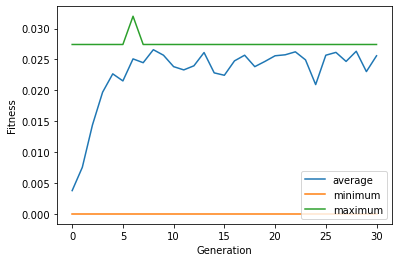

In [6]:
if __name__ == "__main__":
    pop, log, hof = main("graphs/graph_2.txt")
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    import matplotlib.pyplot as plt
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()

## Neutral Landscapes

In this section of the assignment we will explore the neutrality of graph colorings. A mutation to an individual is *neutral* if it does not affect the fitness of that individual.

First, you will need to implement 1-step neutrality. That is, starting with a single valid coloring, make copies in which one gene is changed to one of the other valid colors. Performing this process should produce $n*(k-1)$ individuals. You will then report the fraction of those individuals that have the same fitness as the original coloring.
<a id='question2'></a>
## Question 2:

Below, you will copy and paste your ``eval_graph(graph, individual)`` function from assignment 2 to use as a helper function for question 3. 

In [7]:
def eval_graph(graph, individual):
    edges = []
    section_size = math.ceil(math.log2(graph.k))
    index = 0
    for i in range(0, len(individual), section_size):
        bits = individual[i:i+section_size]
        number = int(''.join(map(str, bits)), 2) 
        graph.color_assignment[index] = number
        index += 1
        
    for i in range (len(graph.graph)):
        edges.append([i,graph.graph[i].vertex])
        temp = graph.graph[i].next
        while temp != None:
            edges.append([i, temp.vertex])
            temp = temp.next
            
    invalids_possible = False
    if math.ceil(math.log2(graph.k)) != math.log2(graph.k):
        invalids_possible = True
        
    bi_color_endpoints = 0
    for i in edges:
        if invalids_possible == True:
            invalid = 2**section_size - 1
            if graph.color_assignment[i[0]] == invalid or graph.color_assignment[i[1]] == invalid:
                return(0,)
        if graph.color_assignment[i[0]] != graph.color_assignment[i[1]]:
            
            bi_color_endpoints += 1
    fitness = bi_color_endpoints/len(edges)
    return(fitness,)


<a id='question3'></a>
## Question 3:

Write the function ``one_neutral(graph, individual)`` that computes the neutrality of single mutations (the fraction of mutations that result in the same fitness that the original coloring produced). The inputs will be a graph object and an individual object and the output will be the neutrality.

In [23]:
import copy
def one_neutral(graph, individual):
    '''
    Function to compute the neutrality of a graph. 
    Inputs: 
        individual: individual object from DEAP toolbox
        graph: graph object containing nodes and edges
    Outputs:
        neutrality: neutrality of the graph
    '''
    base_fitness = eval_graph(graph, individual)
#     print(graph.color_assignment)
    
    color_rollover = (2**math.ceil(math.log2(graph.k)))
    invalids_possible = False
    if math.ceil(math.log2(graph.k)) != math.log2(graph.k):
        invalids_possible = True
        color_rollover -= 1    
    mutants = []
    for i in range(graph.n):
        color_assignment = graph.color_assignment[i]
        temp = (graph.color_assignment[i] + 1) % color_rollover
        while temp != color_assignment:
            mutant = copy.deepcopy(graph.color_assignment)
            mutant[i] = temp
            mutants.append(mutant)
            temp = (temp + 1) % color_rollover
#     print(mutants)       
    
    neutral_mutants = 0
    section_size = math.ceil(math.log2(graph.k))
    for i in mutants:
        if eval_graph(graph, [int(bit) for num in i for bit in format(num, f'0{section_size}b')]) == base_fitness:
            neutral_mutants += 1
    
#     print(neutral_mutants)
    neutrality = neutral_mutants/len(mutants)
    return neutrality
# graph = init_graph("graphs/graph_1.txt")
# register_ind(graph)

# ind = creator.Individual([0, 1, 0, 0, 1, 0, 0, 1])

# one_neutral(graph, ind)   

Your code should return 0.25 for input \[0, 1, 0, 0, 1, 0, 0, 1\]; check that it does:

In [24]:
graph = init_graph("graphs/graph_1.txt")
register_ind(graph)

ind = creator.Individual([0, 1, 0, 0, 1, 0, 0, 1])

one_neutral(graph, ind)

0.25

In [ ]:
'''
This cell contains hidden tests, which are run on submission.
There are five test cases each for graph_1 to graph_4.
'''
